In [68]:
import pandas as pd

In [69]:
import os
import pandas as pd
import re

def read_and_concatenate_files_with_labels_and_user(folder_paths,
     column_names):
    # Initialize an empty DataFrame
    result_df = pd.DataFrame(columns=column_names + ['Label', 
                    'User'])

    # Iterate through folder paths
    for folder_label, folder_path in zip(['Reading',
                     'Speaking', 'Watching'], 
                     folder_paths):
        # Initialize an empty list to store DataFrames
        dfs = []

        # Get a sorted list of files in the folder
        files_to_process = sorted([file_name for 
    file_name in os.listdir(folder_path) 
    if file_name.endswith('.csv')])

        # Iterate through sorted files in the folder
        for file_name in files_to_process:
            file_path = os.path.join(folder_path, file_name)
            
            # Read the CSV file without column names and concatenate rows
            df = pd.read_csv(file_path, header=None, 
                             names=column_names)
            
            # Extract numerical user information from 
            #the file name using regular expression
            user_match = re.search(r'(\d+)', file_name)
            user_info = int(user_match.group(1)) if \
            user_match else None
            
            # Add 'Label' and 'User' columns
            df['Label'] = folder_label
            df['User'] = user_info
            dfs.append(df)

            # Print statement for debugging
            #print(f"Processed file: {file_name}, 
            #User: {user_info}, Label: {folder_label}")

        # Concatenate the list of DataFrames vertically
        result_df = pd.concat([result_df, pd.concat(dfs, 
                    ignore_index=True)], ignore_index=True)

    return result_df

# Example usage:
folder_paths = ['Data/Reading', 
    'Data/Speaking', 'Data/Watching']
column_names = ['EEG1', 'EEG2', 'Acc_X', 'Acc_Y', 'Acc_Z']

result_dataframe = read_and_concatenate_files_with_labels_and_user(
    folder_paths,
                 column_names)

# Print the unique values in the "User" column
#print(result_dataframe['User'].unique())

# Display the resulting DataFrame
print(result_dataframe)


              EEG1        EEG2       Acc_X       Acc_Y       Acc_Z     Label  \
0       842.229919  847.164856 -656.251038  789.063721  136.718964   Reading   
1       845.519897  853.744812 -660.157288  792.969971  136.718964   Reading   
2       847.164856  858.679748 -656.251038  792.969971  136.718964   Reading   
3       843.874939  852.099793 -656.251038  792.969971  140.625214   Reading   
4       847.164856  857.034729 -656.251038  792.969971  136.718964   Reading   
...            ...         ...         ...         ...         ...       ...   
104475  847.164856  857.034729 -703.126099  750.001160  136.718964  Watching   
104476  875.129517  837.294983 -703.126099  750.001160  136.718964  Watching   
104477  852.099793  837.294983 -703.126099  750.001160  136.718964  Watching   
104478  832.360046  870.194580 -707.032349  746.094910  132.812714  Watching   
104479  843.874939  843.874939 -703.126099  746.094910  136.718964  Watching   

       User  
0         1  
1         1

In [70]:
User = result_dataframe['User']

# Separate the data into features (X) and target variable (y)
X = result_dataframe[['EEG1', 'EEG2']].values  # Features for EEG1 and EEG2
y = result_dataframe['Label']  # Target variable

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)


In [71]:
# Filter data for User 1
X_test = X_scaled[User == 4]
y_test = y[User == 4]

# Filter data for training (excluding User 1)
X_train = X_scaled[User != 4]
y_train = y[User != 4]

# Print the shapes of the resulting sets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train: " ,y_train.shape)
print("y_test: ", y_test.shape)

X_train shape: (83413, 2)
X_test shape: (21067, 2)
y_train:  (83413,)
y_test:  (21067,)


In [72]:
import pandas as pd
import numpy as np

# Assuming X_train is your DataFrame and activities_array is your one-hot encoded activities array
sampling_rate = 200 # (HZ)
seconds = 2 # ( s)
# Set the window size
window_size = sampling_rate * seconds # You can adjust this value based on your requirement

# Function to create sliding windows and corresponding labels
def create_sliding_windows(data, labels, window_size):
    X, y = [], []
    for i in range(len(data) - window_size + 1):
        window = data[i:i+window_size]
        label = np.max(labels[i:i+window_size])
        X.append(window)
        y.append(label)
    return np.array(X), np.array(y)




# Create sliding windows and labels
X_windows_train, y_windows_train = create_sliding_windows(
     X_train, y_train.values, window_size)

# Print the shape of the resulting arrays
print("X_windows shape:", X_windows_train.shape)
print("y_labels shape:", y_windows_train.shape)

X_windows_test, y_windows_test = create_sliding_windows(
 X_test , y_test.values, window_size=window_size
)


X_windows shape: (83014, 400, 2)
y_labels shape: (83014,)


In [73]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

encoder = OneHotEncoder(sparse_output=False)

y_train_encoded = encoder.fit_transform(
    y_windows_train.reshape(-1, 1))

y_test_encoded = encoder.transform(
    y_windows_test.reshape(-1, 1))

In [75]:
import tensorflow as tf
from tensorflow import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, \
Flatten, Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt


# Assuming 'X' is your input data of shape 
#(1044, 100, 6) and 'y' is your corresponding labels
train_steps_per_epoch = len(X_windows_train)
val_steps_per_epoch  = len(X_windows_test)
# Define the CNN model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, \
MaxPooling1D, Flatten, Dense, Dropout, LSTM
from tensorflow.keras import regularizers
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import LearningRateScheduler

tf.random.set_seed(42)
l1=0.0
l2=0.001
Dropout_rate=0.05



model = Sequential([
    Conv1D(filters=32, kernel_size=3, activation='relu',
     kernel_regularizer=regularizers.L1L2(l1=l1, l2=l2),
            input_shape=(X_windows_train.shape[1],
                          X_windows_train.shape[2])),
    MaxPooling1D(pool_size=2),
    Dropout(Dropout_rate),

    Conv1D(filters=64, kernel_size=3, activation='relu',
    kernel_regularizer=regularizers.L1L2(l1=l1, l2=l2)),
    
    MaxPooling1D(pool_size=2),
    Dropout(Dropout_rate),



    Flatten(),
    Dense(256, activation='relu', 
    kernel_regularizer=regularizers.L1L2(l1=l1, l2=l2)),
    Dense(128, activation='relu', 
    kernel_regularizer=regularizers.L1L2(l1=l1, l2=l2)),
    Dense(3, activation='softmax')
])










# Compile the model

model.compile(optimizer=optimizers.Adam(learning_rate=0.001), 
              loss=tf.keras.losses.CategoricalCrossentropy()
, 
              metrics=['accuracy'])

# Train the model

history = model.fit(X_windows_train, y_train_encoded, 
                    epochs=50, 
                    validation_data=(X_windows_test, 
                                     y_test_encoded), 
                                     shuffle=True
                  )


#   steps_per_epoch=train_steps_per_epoch,

#  validation_steps=val_steps_per_epoch
# batch_size=128
# epoch = 30
# model.save



# Accessing the history of training
training_accuracy = history.history.get('accuracy') \
    or history.history.get('acc')
training_loss = history.history['loss']
validation_accuracy = history.history.get('val_accuracy')\
or history.history.get('val_acc')
validation_loss = history.history.get('val_loss') \
or history.history.get('validation_loss')

# Plotting accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
if training_accuracy:
    plt.plot(training_accuracy, label='Training Accuracy')
if validation_accuracy:
    plt.plot(validation_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(training_loss, label='Training Loss')
if validation_loss:
    plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

Epoch 1/50
2595/2595 [==============================] - 74s 28ms/step - loss: 0.8134 - accuracy: 0.6581 - val_loss: 0.7275 - val_accuracy: 0.5677
Epoch 2/50
2595/2595 [==============================] - 71s 27ms/step - loss: 0.5672 - accuracy: 0.7691 - val_loss: 0.4328 - val_accuracy: 0.9114
Epoch 3/50
2595/2595 [==============================] - 69s 27ms/step - loss: 0.3939 - accuracy: 0.8740 - val_loss: 0.5355 - val_accuracy: 0.8098
Epoch 4/50
2595/2595 [==============================] - 71s 27ms/step - loss: 0.3455 - accuracy: 0.8921 - val_loss: 0.7502 - val_accuracy: 0.6559
Epoch 5/50
2595/2595 [==============================] - 70s 27ms/step - loss: 0.3130 - accuracy: 0.9025 - val_loss: 0.5279 - val_accuracy: 0.8391
Epoch 6/50
2595/2595 [==============================] - 71s 27ms/step - loss: 0.2919 - accuracy: 0.9097 - val_loss: 0.6515 - val_accuracy: 0.8169
Epoch 7/50
2595/2595 [==============================] - 68s 26ms/step - loss: 0.2729 - accuracy: 0.9184 - val_loss: 0.8585 -

KeyboardInterrupt: 

330/330 [==============================] - 1s 3ms/step


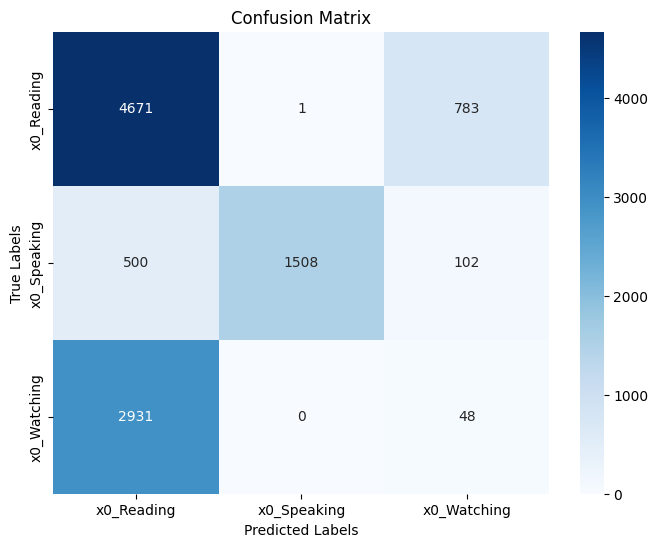

Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.86      0.69      5455
           1       1.00      0.71      0.83      2110
           2       0.05      0.02      0.02      2979

    accuracy                           0.59     10544
   macro avg       0.54      0.53      0.52     10544
weighted avg       0.51      0.59      0.53     10544



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Make predictions on the test set
y_pred = model.predict(X_windows_test)

# Convert one-hot encoded predictions back to labels
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_windows_test, axis=1)

# Create a confusion matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=encoder.get_feature_names_out(),
            yticklabels=encoder.get_feature_names_out())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print("Classification Report:\n", classification_report(y_true_labels, y_pred_labels))


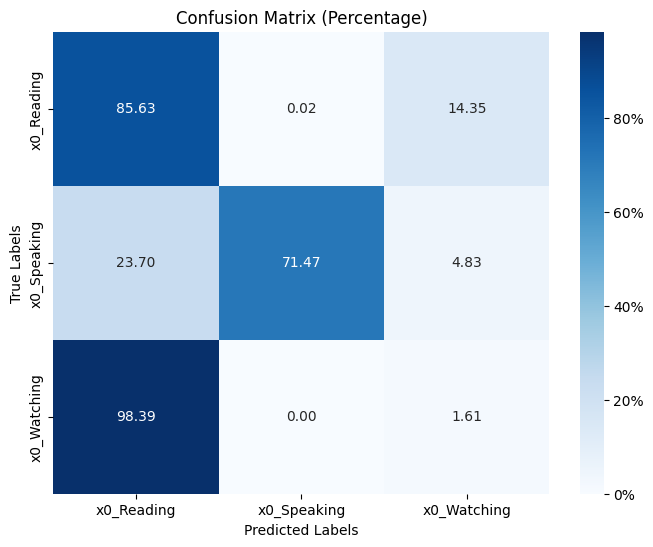

Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.86      0.69      5455
           1       1.00      0.71      0.83      2110
           2       0.05      0.02      0.02      2979

    accuracy                           0.59     10544
   macro avg       0.54      0.53      0.52     10544
weighted avg       0.51      0.59      0.53     10544



In [ ]:
from matplotlib.ticker import FuncFormatter

# Calculate confusion matrix percentages
cm_percentage = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]) * 100

# Plot the confusion matrix with percentages
plt.figure(figsize=(8, 6))
sns.heatmap(cm_percentage, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=encoder.get_feature_names_out(),
            yticklabels=encoder.get_feature_names_out(),
            cbar_kws={'format': FuncFormatter(lambda x, _: f'{x:.0f}%')})  # Use FuncFormatter for direct formatting
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Percentage)')
plt.show()

# Print classification report
print("Classification Report:\n", classification_report(y_true_labels, y_pred_labels))
